In [1]:
a = {  "milo": "https://github.com/eclipse/milo.git",
    "openvsx": "https://github.com/eclipse/openvsx.git",
    "steady": "https://github.com/eclipse/steady.git",
    "xtext": "https://github.com/eclipse/xtext.git"

}

In [3]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 44.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.0 MB/s eta 0:00:00
  Created wheel for ktrain: filename=ktrain-0.41.0-py3-none-any.whl size=25316877 sha256=a324ae0f1d35d370bb581f736a8d6a3608d181fedfd90264124ce41b20fd93d2
  Stored in directory: /root/.cache/pip/wheels/31/61/66/30b15

In [4]:
! pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip

     - 6.9 MB 17.5 MB/s 0:00:00m
  Preparing metadata (setup.py) ... done


In [5]:
import ktrain
from ktrain import text
import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [7]:
def code_bert(project='buildship'):
  MODEL_NAME = 'microsoft/codebert-base'
  t = text.Transformer(MODEL_NAME, maxlen=512, class_names=['not_LA', 'is','set','get'])

  df = pd.read_csv(f"/kaggle/input/combined-data/{project}_combined.csv")

  df = df.drop(columns=["comments"],axis=1)

  # access_modifier,return_type,method_name,parameters,returns,comments,content,label
  df.dropna(subset=['content'])
  X = df['content'].tolist()
  y = df['catagory'].to_list()
  # df['combined'] = df['access_modifier']+' '+df['return_typed']+' '+df['method_name']+'('+df['parameters']+')'+df['content']
  # y = df['label'].map({'positive': 1, 'negative': 0}).values
  # Manually split your dataset into training and validation sets if not already done
  from sklearn.model_selection import train_test_split
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
  # Note: Adjust maxlen according to your data's characteristics
  trn = text.Transformer(MODEL_NAME, maxlen=512, class_names=['not_LA', 'is','set','get'])
  train_data = trn.preprocess_train(X_train, y_train)
  val_data = trn.preprocess_test(X_val, y_val)
  # Get classifier model
  model = trn.get_classifier()

  # Create a Learner object
  learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=8)
      # Train the model
  learner.fit_onecycle(5e-5, 1)
      # Validate the model
  val_metrics = learner.validate(class_names=['not_LA', 'is','set','get'])
  print("Validation Metrics:", val_metrics)
  predictor = ktrain.get_predictor(learner.model, preproc=t)

  pred = predictor.predict(X_val,return_proba=True)
  # prompt: add the code to plot the roc curve for my code
  data = {"get":0,"is":1,"not_LA":2,"set":3}

  # Convert list to DataFrame
  test_df1 = pd.DataFrame(y_val, columns=['cata'])

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for class_name, class_idx in data.items():
      y_true_class = (test_df1['cata'] == class_name).astype(int)

      y_score_class = pred[:, class_idx]
      fpr[class_name], tpr[class_name], _ = roc_curve(y_true_class, y_score_class)
      roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
          # Plot ROC curve for each class
  plt.figure()
  for class_name, class_idx in data.items():
      plt.plot(fpr[class_name], tpr[class_name], label=f'ROC curve (AUC = {roc_auc[class_name]:0.2f}) for {class_name}')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.plot()
  print(predictor.predict('public void setupRegistry() { stateBeforeInjectorCreation = GlobalRegistries.makeCopyOfGlobalState(); if (injector == null) { getInjector(); } stateAfterInjectorCreation.restoreGlobalState(); }'))
  predictor.explain('public void setupRegistry() { stateBeforeInjectorCreation = GlobalRegistries.makeCopyOfGlobalState(); if (injector == null) { getInjector(); } stateAfterInjectorCreation.restoreGlobalState(); }')
  predictor.save(f'./{project}_code_bert_model')

milo


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/499M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 13
	95percentile : 26
	99percentile : 76


/opt/conda/lib/python3.10/site-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 25
	99percentile : 83




begin training using onecycle policy with max lr of 5e-05...
39/39 [==============================] - 50s 1s/step
              precision    recall  f1-score   support

      not_LA       0.52      0.06      0.11       469
          is       1.00      0.88      0.94        34
         set       0.57      0.96      0.71       604
         get       1.00      1.00      1.00       111

    accuracy                           0.61      1218
   macro avg       0.77      0.72      0.69      1218
weighted avg       0.60      0.61      0.51      1218

Validation Metrics: [[ 29   0 440   0]
 [  0  30   4   0]
 [ 27   0 577   0]
 [  0   0   0 111]]


/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


set


/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ktrain/text/predictor.py:147: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


openvsx
preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 70
	99percentile : 126


/opt/conda/lib/python3.10/site-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 21
	95percentile : 70
	99percentile : 117




begin training using onecycle policy with max lr of 5e-05...
9/9 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

      not_LA       0.53      0.67      0.59        66
          is       0.97      0.97      0.97        40
         set       0.80      0.70      0.75       134
         get       1.00      1.00      1.00        23

    accuracy                           0.76       263
   macro avg       0.83      0.84      0.83       263
weighted avg       0.78      0.76      0.77       263

Validation Metrics: [[44  0 22  0]
 [ 0 39  1  0]
 [39  1 94  0]
 [ 0  0  0 23]]


/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


set


/opt/conda/lib/python3.10/site-packages/ktrain/text/predictor.py:147: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


steady
preprocessing train...
language: en
train sequence lengths:
	mean : 24
	95percentile : 98
	99percentile : 211


/opt/conda/lib/python3.10/site-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 27
	95percentile : 110
	99percentile : 316




begin training using onecycle policy with max lr of 5e-05...
37/37 [==============================] - 47s 1s/step
              precision    recall  f1-score   support

      not_LA       0.48      1.00      0.65       293
          is       0.97      0.68      0.80       107
         set       0.88      0.48      0.62       605
         get       0.99      0.97      0.98       155

    accuracy                           0.69      1160
   macro avg       0.83      0.78      0.76      1160
weighted avg       0.80      0.69      0.69      1160

Validation Metrics: [[292   1   0   0]
 [  0  73  34   0]
 [315   1 288   1]
 [  0   0   4 151]]


/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


set


/opt/conda/lib/python3.10/site-packages/ktrain/text/predictor.py:147: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


xtext
preprocessing train...
language: en
train sequence lengths:
	mean : 105
	95percentile : 101
	99percentile : 472


/opt/conda/lib/python3.10/site-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 100
	95percentile : 103
	99percentile : 330




begin training using onecycle policy with max lr of 5e-05...
311/311 [==============================] - 381s 1s/step
              precision    recall  f1-score   support

      not_LA       0.55      0.02      0.05      2640
          is       0.97      0.97      0.97      1748
         set       0.65      0.98      0.78      5032
         get       0.98      0.97      0.98       502

    accuracy                           0.72      9922
   macro avg       0.79      0.74      0.69      9922
weighted avg       0.70      0.72      0.63      9922

Validation Metrics: [[  65    1 2574    0]
 [   0 1697   51    0]
 [  54   49 4921    8]
 [   0    0   15  487]]


/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


set


/opt/conda/lib/python3.10/site-packages/ktrain/text/predictor.py:147: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


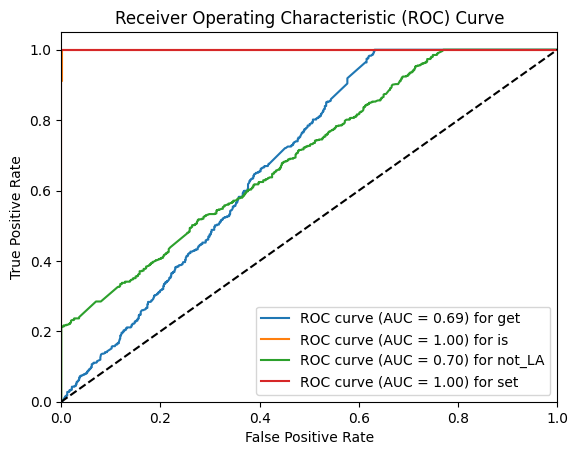

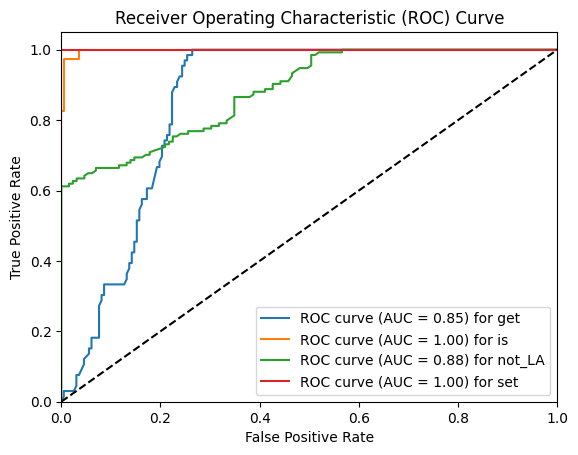

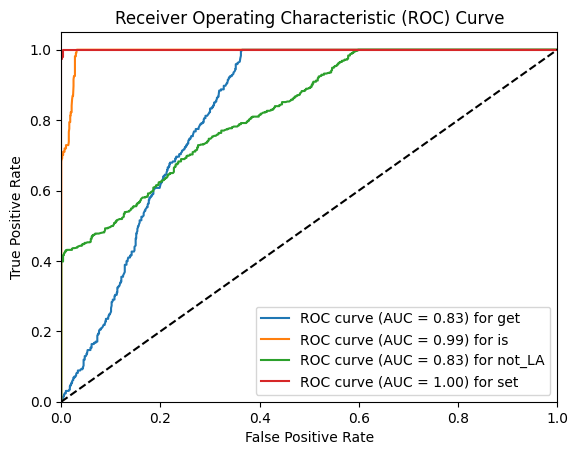

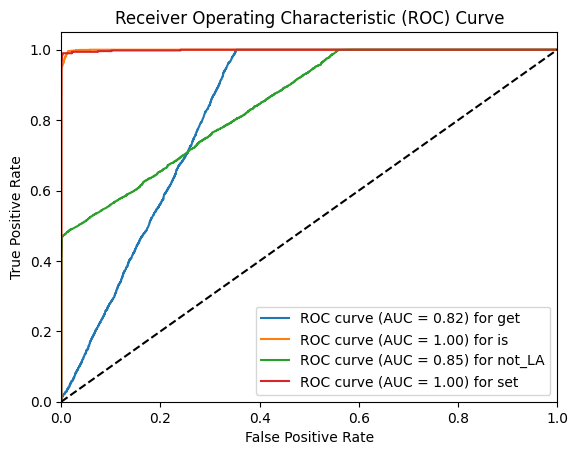

In [8]:
for project,url in a.items():
  print(project)
  code_bert(project)